#Mount drive to colab and install things

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
#use datatable to speed up csv reading
#!pip3 install datatable

Mounted at /content/drive
/content/drive/MyDrive


#Import Libraries & Set Seeds & Initialize TPU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import gc

pd.set_option('display.max_columns', 500)

#set all seeds for consistance result
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
#import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
#tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


##Initialize tensorflow enviroment for TPU acceleration

In [ ]:
#Use TPU in tensorflow
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

#create a TPUStrategy to distristue model to all avaliable TPU cores
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.5.141.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.141.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#Load data

In [ ]:
datapath = '/content/drive/MyDrive/jane-street-market-prediction/train.csv'
#Use datatable to speed up import
#dataSet = dt.fread(datapath).to_pandas()

#Use panda to load dataset
dataSet = pd.read_csv(datapath)

print('dataset memm usage before type conversion...')
dataSet.info()
#change data types to reduce memory usage
dataSet.feature_0 = dataSet.feature_0.astype(np.int8)
dataSet.date = dataSet.date.astype(np.int16)
dataSet.ts_id = dataSet.ts_id.astype(np.int32)

#convert data value over +/-0.0001 from float 64 to float 32
for i in dataSet:
        if dataSet[i].dtype == np.float64:
                if (((dataSet[i]<0.0001) & (dataSet[i]>-0.0001)).mean()) <0.001:
                    dataSet[i] = dataSet[i].astype(np.float32)

gc.collect()
print('dataset memm usage after type conversion...')
dataSet.info()

dataset memm usage before type conversion...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB
dataset memm usage after type conversion...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.3 GB


# Preprocess data

In [ ]:
#drop data before day 85, drop day 294 data
dataSet = dataSet.query('date > 85').reset_index(drop = True)
dataSet = dataSet.query('date != 294').reset_index(drop = True)

#exclude data with weight = 0, as themn dont contribute to scoring
dataSet = dataSet.query('weight > 0').reset_index(drop = True)

#assemble stock id
dataSet['stock_id'] = dataSet['feature_41'] + dataSet['feature_42'] + dataSet['feature_43']
dataSet = dataSet.drop(['feature_41', 'feature_42', 'feature_43'], axis = 1)

#action = if all resp returns >0: , else: 0
dataSet['action'] =  ((dataSet['resp'] > 0 ).astype('int'))

#generate feature list to be used in generating X, Y
features = [c for c in dataSet.columns if 'feature' in c]
features.extend(['date', 'ts_id', 'stock_id', 'weight', 'action'])
resp_cols = ['resp_1']

#sort value based on date and order of tranction order
dataSet = dataSet.sort_values(['date', 'ts_id'], ascending = [True, True])

print('Data Preprocessing Done!')

Data Preprocessing Done!


##Generate X & Y

In [ ]:
#X: vlaues in features(no resp), include action
X = dataSet[features]
# multiple output on all time horizon, convert resp to 0(negative return value) and 1(positive return value)
Y = np.stack([(dataSet[c] > 0).astype('int') for c in resp_cols]).T
Y = pd.DataFrame(data=Y, columns=["resp"])

print(X.shape)
print(Y.shape)

#no random split, last 13% data (about 50 days) is test data, simulate future data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,
                                                Y, 
                                                test_size = 0.13,
                                                shuffle=False)

#generate test data frame for a baseline score(best possible score)
#replace resp value from 0 or 1 back to origonal values
test_df = pd.concat([Xtest, Ytest], axis = 1)
test_df['resp'] = dataSet['resp']
test_df.head()


#drop feature 'action' in Xtrain, Xtest
Xtrain = Xtrain.drop(['action'], axis = 1)
Xtest = Xtest.drop(['action'], axis = 1)

#fill nan value with mean vlaue of the column
Xtrain.fillna(Xtrain.mean(), inplace=True)
Xtest.fillna(Xtest.mean(), inplace=True)
Ytrain.fillna(Ytrain.mean(), inplace=True)
Ytest.fillna(Ytest.mean(), inplace=True)

#fit data between 0 - 1
#from sklearn.preprocessing import MinMaxScaler
#scalr = MinMaxScaler()
#Xtrain =  scalr.fit_transform(Xtrain)
#Xtest = scalr.fit_transform(Xtest)

(1571404, 132)
(1571404, 1)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
test_df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
1367121         -1   0.717442   1.249467   2.933695   3.624768   4.465428   
1367122          1   5.462450   7.197752   0.869326   0.947012   2.876072   
1367123          1   0.201020   0.798035   1.853281   2.362980  -1.996377   
1367124         -1  -1.577996  -1.207111   1.030738   1.436595   1.187680   
1367125          1  -1.570902  -0.807422  -1.729319  -2.950246  -1.014748   

         feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
1367121   5.535522  -1.868083  -2.611106   0.997481    1.293976   -2.533288   
1367122   3.447118   0.633176   0.914056   3.127353    3.305830    0.992807   
1367123  -2.559997   0.641738   1.059236  -0.468504    0.034711   -0.932271   
1367124   1.723645   1.056928   1.965096  -1.999915   -1.154001    1.107896   
1367125  -1.786523  -0.765484  -1.267119  -1.969993   -0.921467   -0.305280   

         feature_12  feature_13  feature_14  feature_15  feature_16  \
1367121   -4.630593   -3.746904   -3.777429    0.664660    1.515266   
1367122    2.093511    1.925361    2.246872    2.171258    3.713750   
1367123   -1.736169    0.615167    1.000279   -0.252594    0.112147   
1367124    2.920580    0.219567    0.760819   -1.198921   -1.414900   
1367125   -0.181927   -0.852684   -0.353041   -0.792940   -0.222366   

         feature_17  feature_18  feature_19  feature_20  feature_21  \
1367121   -1.993900   -3.278318   -0.910585   -1.453337   -4.197803   
1367122    1.626767    2.766942    2.942536    4.550702    2.144067   
1367123    0.843604    1.576051    0.615778    1.071941    1.085633   
1367124   -0.053081   -0.084153   -0.175219   -0.257826   -0.093211   
1367125    0.241025    0.759935    0.222707    0.766443    0.519700   

         feature_22  feature_23  feature_24  feature_25  feature_26  \
1367121   -3.474359   -3.338815   -5.013309   -1.133786   -1.677404   
1367122    1.867298    2.327633    3.794943    3.132957    4.655910   
1367123    1.013763    1.352825    2.462059    0.712721    1.161975   
1367124   -0.103696   -0.121256   -0.178481   -0.169769   -0.242708   
1367125    0.820590    0.217170    0.749298    0.285239    0.898936   

         feature_27  feature_28  feature_29  feature_30  feature_31  \
1367121    1.312822    2.495178    1.619680    2.728476    2.440045   
1367122   -0.157649   -0.329170   -0.819942   -1.373966   -0.335486   
1367123   -0.631441   -1.216008   -0.796206   -1.475859   -1.096678   
1367124    1.089685    2.481595    0.113300    0.286279    1.649692   
1367125   -0.563988   -1.402057   -0.566352   -1.528302   -0.198735   

         feature_32  feature_33  feature_34  feature_35  feature_36  \
1367121    4.807823    4.221111    5.803380    3.383857    4.361152   
1367122   -0.791712   -0.629262   -0.813582   -1.221350   -1.379539   
1367123   -2.348808   -0.607437   -0.880242   -1.182438   -1.485517   
1367124    3.984660    0.876959    1.513275    0.187591    0.333584   
1367125   -0.895407   -0.393231   -0.914079   -0.802182   -1.540012   

         feature_37  feature_38  feature_39  feature_40  feature_44  \
1367121   -2.883491   -4.017387    2.483919    4.964190    3.108932   
1367122    1.979058    2.700351   -0.051271   -0.120583    4.452359   
1367123    2.162213    3.234833   -1.139202   -2.432337    1.601954   
1367124   -0.034547   -0.045462    0.936638    2.261852    1.696143   
1367125    0.075265    0.214276   -1.466752   -4.253304   -0.158902   

         feature_45  feature_46  feature_47  feature_48  feature_49  \
1367121    0.186837    0.504977    1.102834    1.434619    1.856708   
1367122    0.711198    2.508035    2.102105    2.841915    3.643999   
1367123    0.576352    3.070868    2.389325    3.681907    5.410131   
1367124    1.052225   -1.713870   -2.651688   -2.128218   -1.513071   
1367125   -0.231071   -0.690713   -1.313318   -0.772528   -0.266496   

         feature_50  feature_51  feature_52  feature_53  feature_54  \
1367121    

# Decision Tree Classification

In [ ]:
#从这里copy cell就好，如果一样就不用管了
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,f1_score
from sklearn.model_selection import cross_val_score,GridSearchCV

In [ ]:
DTmodel = DecisionTreeClassifier(max_depth=3)
DTmodel.fit(Xtrain,Ytrain)
Ypred_dt = DTmodel.predict(Xtest)

Text(0.5, 1.0, 'ROC curve')

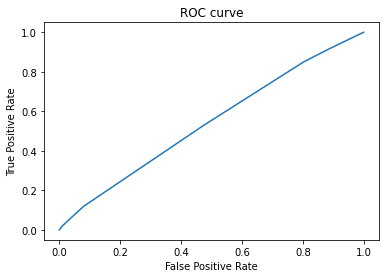

In [ ]:
y_pred_probability = DTmodel.predict_proba(Xtest)
fpr,tpr,thres = roc_curve(Ytest,y_pred_probability[:,1])
plt.plot(fpr,tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")

In [ ]:
# accuracy score
score_accuracy = accuracy_score(Ypred_dt,Ytest)
print(score_accuracy)
# auc score (cross validation)
score_auc = roc_auc_score(Ytest,y_pred_probability[:,1])
print(score_auc)
# f1 score
score_f1 = f1_score(Ypred_dt,Ytest)
print(score_f1)

0.5273517620164184
0.5419075713998156
0.5320227605393512


Decision Tree model: hyperparameter tunning

In [ ]:
# 主要是这个
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Specify the range of each parameter in the decision tree classifier
parameters = {'max_depth': [5, 7, 9], 'criterion':['gini', 'entropy'], 'min_samples_split':[5, 7, 9]}
# Build a decision tree classifier
model = DecisionTreeClassifier()  #For parameter tuning, there is no need to pass in fixed parameters

# Grid search
grid_search = GridSearchCV(model, parameters, scoring='roc_auc', cv=5)
grid_search.fit(Xtrain, Ytrain)

# Obtain the optimal value of the parameter
grid_search.best_params_


{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5}

Decision Tree model: Rebuild the Decision tree model based on the results of hyperparameters tuning

In [ ]:
# 还有这个
# Rebuild the Decision tree model based on the results of hyperparameters tuning
model=DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_split= 5)
model.fit(Xtrain,Ytrain)

# View overall forecast accuracy
y_pred=model.predict(Xtest)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred,Ytest)
print(score)

# View the new AUC value
# Predict non-default & probability of default
y_pred_proba = model.predict_proba(Xtest)
y_pred_proba[:,1] # If you want to simply check the probability of default, check the second column of y_pred_proba

from sklearn.metrics import roc_auc_score
score = roc_auc_score(Ytest,y_pred_proba[:,1])
print(score)

# f1 score
score_f1 = f1_score(Ypred_dt,Ytest)
print(score_f1)

0.5375777720123555
0.5567388000018983
0.5320227605393512


#Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs = -1, verbose = 1)
logistic_model.fit(Xtrain, Ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
Ypred_lr = logistic_model.predict(Xtest)
print(Ypred_lr[:5])
#Evalution of perdicted resp classification result
for i in range(len(Ypred_lr)):
    if (Ypred_lr[i]>0.5): Ypred_lr[i] = 1
    else: Ypred_lr[i] = 0

pred_action_df = pd.DataFrame(data = Ypred_lr, dtype = np.int8)

print(Ytest.shape)
from sklearn.metrics import f1_score, classification_report, accuracy_score
print(classification_report(Ytest, Ypred_lr))
print(accuracy_score(Ytest, Ypred_lr))
print(f1_score(Ytest, Ypred_lr))
print(roc_auc_score(Ytest, Ypred_lr))

[1 1 1 1 1]
(204283, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    102568
           1       0.50      1.00      0.66    101715

    accuracy                           0.50    204283
   macro avg       0.25      0.50      0.33    204283
weighted avg       0.25      0.50      0.33    204283

0.4979122100223709
0.6648082667206975
0.5


#Competition Score

##Generate Action Prediction Data Frame Based on test data

In [ ]:

#generate action data for evaluation 
#if (resp = 1): action = 1, else: action = 0
#take a test_df data frame(generated in preprocessing) and resp ndarray from prediction
#return a full test data frame for score and evaluation

def generate_action_df (test_df, Y):
  action = []
  for i in range(len(Y)):
    if ((Y[i]>0.5)): action.append(1)
    else: action.append(0)
  action_np = np.asarray(a = action)

  action_df = test_df.drop(['action'], axis = 1)
  action_df = action_df.reset_index(drop = True)
  action_df.insert(loc = 0, column = 'action', value = action_np)

  return action_df

In [ ]:
pred_dt_df = generate_action_df(test_df = test_df, Y = Ypred_dt)
print('done')

done


##Scoring Perfiction Result (Same as competition)

In [ ]:
# score for both test and perdiction for comparsion
def utility_scoring(df):
    """
    To get the utility score used in the challenge. From Kaggle
    """
    from math import sqrt
    u = 0
    Pi = []
    Pis = []
    count_i = len(df['date'].unique())
    for i in list(df['date'].unique()):
        tmp = df[df['date'] == i][["date","weight","resp","action"]]
        tmp["mult"] = tmp['weight'] * tmp['resp'] * tmp['action']
        Pi.append(tmp["mult"].sum())
        Pis.append((tmp["mult"].sum())**2)
    
    t =  sum(Pi)/sqrt(sum(Pis)) * sqrt(250/count_i)
    u = min(max(t,0),6)*sum(Pi)
    return u

In [ ]:
print("decision tree: ", utility_scoring(pred_dt_df))

decision tree:  327.498178302646
